In [ ]:
!pip install gluonts
!pip install autogluon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to p

In [ ]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.metrics import mse
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short.csv')
df = df[df.unique_id == "BE"]
df

,unique_id,ds,y
0,BE,2016-10-22 00:00:00,70.00
1,BE,2016-10-22 01:00:00,37.10
2,BE,2016-10-22 02:00:00,37.10
3,BE,2016-10-22 03:00:00,44.75
4,BE,2016-10-22 04:00:00,37.10
...,...,...,...
1675,BE,2016-12-30 19:00:00,57.42
1676,BE,2016-12-30 20:00:00,57.56
1677,BE,2016-12-30 21:00:00,52.18
1678,BE,2016-12-30 22:00:00,54.38


In [ ]:
# Initialize variables
historical_days = 35
window_size = 24 * historical_days  # 24 hours a day
prediction_length = 24  # Predict 24 hours

columns_to_extract = [str(i/10) for i in range(1,10)]

pred_dict = {}
actual_dict = {}
best_model_name = []

# Iterate through the time series data by rolling window
for start_idx in range(len(df) - window_size):
    # Slice the data for the current rolling window
    rolling_window = df.iloc[start_idx : start_idx + window_size]

    # Convert rolling_window to a TimeSeriesDataFrame
    train_data = TimeSeriesDataFrame.from_data_frame(
        rolling_window,
        id_column='unique_id',  # Specify the item_id column
        timestamp_column='ds'  # Specify the timestamp column
    )

    # Fit the TimeSeriesPredictor on the rolling window
    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        path="multiple-timeseries/electric-hourly-1week_rollingwindow",
        freq="H",
        target="y",
        eval_metric="MSE",
    )
    predictor.fit(train_data, presets="fast_training", random_seed=42)

    # Predict the next hour
    prediction = predictor.predict(train_data, random_seed=42)

    # Add the predictions to the list
    pred_dict[df.iloc[start_idx + window_size].ds] = prediction[columns_to_extract].to_numpy().transpose()
    actual_dict[df.iloc[start_idx + window_size].ds] = df.iloc[start_idx + window_size].y

    best_model_name.append(predictor.info()["best_model"])

Streaming output truncated to the last 5000 lines.
	0.37    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. 
	-193.8171     = Validation score (-MSE)
	8.85    s     = Training runtime
	0.14    s     = Validation (prediction) runtime
Training timeseries model ETS. 
	-212.0406     = Validation score (-MSE)
	0.02    s     = Training runtime
	0.61    s     = Validation (prediction) runtime
Training timeseries model Theta. 
	-174.4292     = Validation score (-MSE)
	0.02    s     = Training runtime
	0.11    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'DirectTabular': 0.33, 'ETS': 0.28, 'SeasonalNaive': 0.39}
	-74.0928      = Validation score (-MSE)
	0.72    s     = Training runtime
	0.76    s     = Validation (prediction) runtime
Training complete. Models trained: ['Naive', 'SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'ETS', 'Theta', 'WeightedEnsemble']
Total runtime: 13.09 s
Best model: WeightedEnsem

In [ ]:
# Create an empty list to store the data for the DataFrame
data_pred = []

# Iterate through the pred_dict
for time, predictions in pred_dict.items():
    row = {'time' : time}  # Start with the time as the first element
    for i in range(predictions.shape[1]):
        row[f'step{i+1}'] = predictions[:, i]  # Append each array of length 9 as separate column values
    data_pred.append(row)

# Create the DataFrame
pred_df = pd.DataFrame(data_pred)

actual_df = pd.DataFrame(list(actual_dict.items()), columns=['time', 'actual'])

# Convert 'time' column to datetime objects if they are not already
actual_df['time'] = pd.to_datetime(actual_df['time'])
pred_df['time'] = pd.to_datetime(pred_df['time'])

# Merge the DataFrames on the 'time' column
merged_df = pd.merge(actual_df, pred_df, on='time', how='inner')
merged_df['best_model'] = best_model_name
merged_df

,time,actual,step1,step2,step3,step4,step5,step6,step7,step8,...,step16,step17,step18,step19,step20,step21,step22,step23,step24,best_model
0,2016-11-26 00:00:00,42.44,"[6.3586257203027206, 15.894302208285332, 22.77...","[1.758756253817959, 11.705911966789433, 18.878...","[-0.43400810223534236, 9.82888672506275, 17.22...","[-1.3987492290904004, 9.130325984495089, 16.72...","[-1.6523195456770143, 9.111265295912416, 16.87...","[0.0764030551027235, 11.052000806340589, 18.96...","[9.251581027445022, 20.422144770498466, 28.476...","[21.468234228251177, 32.82026789181439, 41.005...",...,"[17.877202979870745, 30.393075644661998, 39.41...","[18.86699871558059, 31.50516435197497, 40.6181...","[22.139651362259364, 34.896562976414316, 44.09...","[22.939801210571233, 35.81220362849601, 45.094...","[21.06703497388316, 34.05192689468229, 43.4149...","[13.528259107987884, 26.62286172571548, 36.064...","[8.598549207438506, 21.800280008174493, 31.319...","[7.990931354076542, 21.297382039921242, 30.892...","[-4.086535991913383, 12.860709050918397, 25.08...",WeightedEnsemble
1,2016-11-26 01:00:00,32.79,"[-5.628175333745394, 7.990253558759347, 17.810...","[-7.291068527037059, 6.638407054639122, 16.682...","[-9.076499514843109, 5.091650585955824, 15.307...","[-9.81815019444287, 4.551211833590815, 14.9125...","[-7.445064287732246, 7.101569006843328, 17.590...","[1.4011135450055734, 16.108012314975525, 26.71...","[12.352876157942159, 27.2071542427655, 37.9181...","[16.994977573770868, 31.986432980147434, 42.79...",...,"[9.784690775258799, 25.65591907435037, 37.1001...","[12.952325582804818, 28.91599797534271, 40.426...","[14.31953574167579, 30.37297097275274, 41.9486...","[12.753191790900443, 28.893929199003036, 40.53...","[5.826221013913461, 22.051991846088814, 33.751...","[1.2848103961702204, 17.593514088557935, 29.35...","[-0.1771814043811677, 16.212502966053208, 28.0...","[-3.0468219377906904, 13.422022622454875, 25.2...","[-23.95831511976896, -2.0821220804872267, 13.6...",WeightedEnsemble
2,2016-11-26 02:00:00,34.56,"[-21.211164781858862, -2.8010486166072974, 10....","[-23.382787693040157, -4.7128840752761505, 8.7...","[-23.955755075652515, -5.086509534437406, 8.51...","[-22.173508525232545, -3.136209968791083, 10.5...","[-13.050573805255876, 6.13478242979727, 19.968...","[-0.7244772448440386, 18.594733363291514, 32.5...","[4.5015888188999424, 23.943891226728912, 37.96...","[3.0334725711718624, 22.590346032638216, 36.69...",...,"[0.6250498016255727, 20.91671314044684, 35.548...","[2.488871062056948, 22.85774408152203, 37.5451...","[0.44236862660525, 20.88621193177395, 35.62766...","[-6.035013485821396, 14.48174495060524, 29.275...","[-9.812156138210637, 10.775622557833996, 25.62...","[-11.528186531390576, 9.128858024842213, 24.02...","[-14.243493327788496, 6.481186618194021, 21.42...","[-19.956891892610436, 0.8339029639864055, 15.8...","[-49.75797504934046, -21.536555259132108, -1.1...",WeightedEnsemble
3,2016-11-26 03:00:00,34.70,"[-23.4953413430697, -4.76475500928632, 8.74131...","[-24.431282681326362, -5.447038919654755, 8.24...","[-22.324516268743842, -3.1456343169522714, 10....","[-13.575685558239714, 5.767283978148099, 19.71...","[-0.7957499355963922, 18.691783664885094, 32.7...","[5.087248232795401, 24.70547773740662, 38.8516...","[3.362541755435652, 23.10095854777921, 37.3337...","[0.5621218900669414, 20.41240628223121, 34.725...",...,"[2.642544029183335, 23.21027997078001, 38.0410...","[0.9174844133395045, 21.560608172210546, 36.44...","[-5.837658154166237, 14.878666868490688, 29.81...","[-10.033275513277706, 10.754244112775755, 25.7...","[-11.721341041743912, 9.135523028040108, 24.17...","[-14.601065800241798, 6.323429711191438, 21.41...","[-19.969352041625648, 1.0211829141002746, 16.1...","[-28.65627243603076, -7.601182637454278, 7.581...","[-49.65885027397485, -21.035788933166366, -0.3...",WeightedEnsemble
4,2016-11-26 04:00:00,33.00,"[-22.392367844163047, -3.9506253638886224, 9.3...","[-21.077490144357583, -2.3859509287437364, 11...

In [ ]:
merged_df.to_pickle('/content/drive/My Drive/autogluon_elec_BE_C5w_P1h_predinterval.pkl')

In [ ]:
import pandas as pd

#Predictions from Auto-gluon

pred_autogluon = pd.read_pickle('/content/drive/My Drive/autogluon_elec_BE_C5w_P1h_predinterval.pkl')
pred_autogluon.drop(columns = ['actual'], inplace = True)

#predictions from Lag-LLama model
pred_lagllama = pd.read_pickle('/content/drive/My Drive/lag_llama_elec_BE_C5w_P24h_pred_interval.pkl')

In [ ]:
# Merge the two dataframes
merged_df = pd.merge(pred_lagllama, pred_autogluon, on='time', suffixes=('_lagllama', '_autogluon'))

In [ ]:
merged_df_step1 = merged_df[['time', 'actual', 'step1_lagllama', 'step1_autogluon']]

In [ ]:
def calculate_sigma(percentiles):
    z_10, z_90 = -1.28155, 1.28155  # Standard normal quantiles
    sigma_factor = z_90 - z_10  # 2.5631
    return (percentiles[8] - percentiles[0]) / sigma_factor

def calculate_sigma_from_array(values):
    return np.std(values, ddof=0)  # Population standard deviation

# Apply function using lambda
merged_df_step1.loc[:,'autogluon_sigma'] = merged_df_step1['step1_autogluon'].apply(lambda x: calculate_sigma(x))
merged_df_step1.loc[:,'lagllama_sigma'] = merged_df_step1['step1_lagllama'].apply(calculate_sigma_from_array)
merged_df_step1.loc[:,'autogluon_mean'] = merged_df_step1['step1_autogluon'].apply(lambda x: x[4])
merged_df_step1.loc[:,'lagllama_mean'] = merged_df_step1['step1_lagllama'].apply(lambda x: np.mean(x))

merged_df_step1

<ipython-input-6-7e4073a4acaf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_step1.loc[:,'autogluon_sigma'] = merged_df_step1['step1_autogluon'].apply(lambda x: calculate_sigma(x))
<ipython-input-6-7e4073a4acaf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_step1.loc[:,'lagllama_sigma'] = merged_df_step1['step1_lagllama'].apply(calculate_sigma_from_array)
<ipython-input-6-7e4073a4acaf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,time,actual,step1_lagllama,step1_autogluon,autogluon_sigma,lagllama_sigma,autogluon_mean,lagllama_mean
0,2016-11-26 00:00:00,42.439999,"[4.0994377, 24.56957, 25.026915, 51.294598, 57...","[6.3586257203027206, 15.894302208285332, 22.77...",21.675451,14.976864,34.136799,41.269703
1,2016-11-26 01:00:00,32.790001,"[45.204742, 42.66936, 44.460785, 28.407608, 35...","[-5.628175333745394, 7.990253558759347, 17.810...",30.955914,12.715070,34.043376,34.689159
2,2016-11-26 02:00:00,34.560001,"[30.453667, 34.467197, 46.51206, 40.757385, 34...","[-21.211164781858862, -2.8010486166072974, 10....",41.847850,11.546180,32.418948,28.046986
3,2016-11-26 03:00:00,34.700001,"[35.77533, 32.77755, 29.576519, 42.10489, 24.8...","[-23.4953413430697, -4.76475500928632, 8.74131...",42.576308,11.404819,31.068326,30.210943
4,2016-11-26 04:00:00,33.000000,"[53.59996, 18.78891, 32.612152, 48.101723, 24....","[-22.392367844163047, -3.9506253638886224, 9.3...",41.919740,11.468176,31.329875,30.338047
...,...,...,...,...,...,...,...,...
835,2016-12-30 19:00:00,57.419998,"[63.26205, 46.166183, 48.40554, 68.381874, 42....","[37.31999681045353, 43.647726221696715, 48.279...",17.184568,15.069600,58.419122,62.299332
836,2016-12-30 20:00:00,57.560001,"[52.504467, 53.931313, 46.419052, 68.53627, 64...","[36.535905392759915, 41.59007461952642, 45.286...",13.599657,10.312839,53.268339,49.044796
837,2016-12-30 21:00:00,52.180000,"[31.13247, 35.704586, 48.348347, 45.807323, 55...","[41.74705673633799, 45.47520231417374, 48.1765...",9.009310,12.102182,53.116535,44.493927
838,2016-12-30 22:00:00,54.380001,"[50.778362, 43.616276, 54.76749, 44.84922, 59....","[36.505148234348106, 41.918932176009044, 45.84...",13.079227,10.565873,53.011837,44.989296


In [ ]:
merged_df = merged_df_step1[['time', 'actual', 'autogluon_sigma', 'autogluon_mean', 'lagllama_sigma', 'lagllama_mean']]
merged_df.rename(columns = {'autogluon_mean':'step1_autogluon','lagllama_mean':'step1_lagllama'}, inplace = True)

<ipython-input-7-5cc955068ea2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.rename(columns = {'autogluon_mean':'step1_autogluon','lagllama_mean':'step1_lagllama'}, inplace = True)


In [ ]:
from sklearn.metrics import mean_squared_error

# Initialize list to store the differences
mse_lagllama = []
mse_autogluon = []
mse_avg = []
mse_04l_06a = []
mse_025l_075a = []
mse_075l_025a = []
mse_max = []
mse_min = []

# Loop through the prediction steps (1 to 24)
for x in range(1, 2):
    # Calculate the differences
    temp = merged_df.copy()
    temp['actual_lag'] = merged_df['actual'].shift(-x+1)
    temp['avg'] = (merged_df[f'step{x}_lagllama'] + merged_df[f'step{x}_autogluon']) / 2
    temp['0.4l_0.6a'] = merged_df[f'step{x}_lagllama'] * 0.4 + merged_df[f'step{x}_autogluon'] * 0.6
    temp['0.25l_0.75a'] = merged_df[f'step{x}_lagllama'] * 0.25 + merged_df[f'step{x}_autogluon'] * 0.75
    temp['0.75l_0.25a'] = merged_df[f'step{x}_lagllama'] * 0.75 + merged_df[f'step{x}_autogluon'] * 0.25

    if x == 1:
      temp2 = temp
    else:
      temp2 = temp.iloc[:(-x+1)]

    mse_lagllama.append(mean_squared_error(temp2[f'step{x}_lagllama'], temp2['actual_lag']))
    mse_autogluon.append(mean_squared_error(temp2[f'step{x}_autogluon'], temp2['actual_lag']))
    mse_avg.append(mean_squared_error(temp2['avg'], temp2['actual_lag']))
    mse_04l_06a.append(mean_squared_error(temp2['0.4l_0.6a'], temp2['actual_lag']))
    mse_025l_075a.append(mean_squared_error(temp2['0.25l_0.75a'], temp2['actual_lag']))
    mse_075l_025a.append(mean_squared_error(temp2['0.75l_0.25a'], temp2['actual_lag']))

print(f"MSE for LagLLama: {mse_lagllama}")
print(f"MSE for AutoGluon: {mse_autogluon}")
print(f"MSE for Average Difference: {mse_avg}")
print(f"MSE for 0.4l_0.6a: {mse_04l_06a}")
print(f"MSE for 0.25l_0.75a: {mse_025l_075a}")


MSE for LagLLama: [487.2017822265625]
MSE for AutoGluon: [203.83420447374655]
MSE for Average Difference: [265.45332589078464]
MSE for 0.4l_0.6a: [240.3191545100433]
MSE for 0.25l_0.75a: [214.62759574626426]


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

mse_cv_min_step = []
mse_cv_max_step = []
mse_cv_avg_step = []
mse_train_step = []
mse_test_step = []
mse_overall_step = []
coeff_lagllama_step = []
coeff_autogluon_step = []

for x in range(1, 2):
  # Prepare the data for the regression model
  if x == 1:
    X = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']]
    y = merged_df['actual']
  else:
    X = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']].iloc[:(-x+1)]
    y = merged_df['actual'].shift(-x+1).iloc[:(-x+1)]

  # Split the data into training and testing sets
  X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # Important: shuffle=False to maintain time order

  # Define the time series cross-validation
  tscv = TimeSeriesSplit(n_splits=5)

  # Initialize lists to store results
  mse_scores = []

  # Perform cross-validation
  for train_index, val_index in tscv.split(X_cv):
      X_train, X_val = X_cv.iloc[train_index], X_cv.iloc[val_index]
      y_train, y_val = y_cv.iloc[train_index], y_cv.iloc[val_index]

      # Initialize and train the linear regression model
      model = LinearRegression(fit_intercept = False)
      model.fit(X_train, y_train)

      # Make predictions on the test set
      y_val_pred = model.predict(X_val)

      # Calculate MSE and store results
      mse = mean_squared_error(y_val, y_val_pred)
      mse_scores.append(mse)

  # Print the average MSE across all folds
  avg_mse = np.mean(mse_scores)
  min_mse = np.min(mse_scores)
  max_mse = np.max(mse_scores)
  mse_cv_avg_step.append(avg_mse)
  mse_cv_min_step.append(min_mse)
  mse_cv_max_step.append(max_mse)
  #print(f"Average MSE across folds: {avg_mse}")

  #train model on overall train data (cv)
  model = LinearRegression(fit_intercept = False)
  model.fit(X_cv, y_cv)

  coefficients = model.coef_
  coeff_lagllama_step.append(coefficients[0])
  coeff_autogluon_step.append(coefficients[1])

  #mse on overall data
  y_cv_pred = model.predict(X_cv)
  mse_train = mean_squared_error(y_cv, y_cv_pred)
  #print(f"MSE on overall train data: {mse_train}")
  mse_train_step.append(mse_train)

  #test the model on test data
  y_test_pred = model.predict(X_test)
  mse_test = mean_squared_error(y_test, y_test_pred)
  mse_test_step.append(mse_test)
  #print(f"MSE on test data: {mse_test}")

  #mse on complete data
  y_pred = model.predict(X)
  mse_overall = mean_squared_error(y, y_pred)
  mse_overall_step.append(mse_overall)
  #print(f"MSE on complete data: {mse_overall}")

In [ ]:
#print all the lists difened ending with _step

# Print all list defined ending with _step
#print(f"mse_cv_avg_step: {mse_cv_avg_step}")
#print(f"mse_train_step: {mse_train_step}")
#print(f"mse_test_step: {mse_test_step}")
print(f"mse_overall_step: {mse_overall_step}") #overall- train and test data.
print(f"coeff_lagllama_step: {coeff_lagllama_step}")
print(f"coeff_autogluon_step: {coeff_autogluon_step}")


mse_overall_step: [194.8008542076603]
coeff_lagllama_step: [np.float64(-0.008911538035707663)]
coeff_autogluon_step: [np.float64(0.9598236770188527)]


In [ ]:
import numpy as np
import pandas as pd

def ensemble_statistics_df(df, mu1_col, sigma1_col, mu2_col, sigma2_col, w1, w2, rho=0):
    """
    Compute ensemble mean, standard deviation, and confidence interval for each row in a DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing model statistics.
    - mu1_col, sigma1_col: Column names for Model 1 mean and standard deviation.
    - mu2_col, sigma2_col: Column names for Model 2 mean and standard deviation.
    - w1, w2: Weights for each model (w1 + w2 = 1).
    - rho: Correlation between the models (default is 0 for independence).

    Returns:
    - DataFrame with additional columns for ensemble mean, standard deviation, and confidence interval.
    """
    # Compute ensemble mean
    df['ensemble_mean'] = w1 * df[mu1_col] + w2 * df[mu2_col]

    # Compute ensemble variance
    df['ensemble_variance'] = (
        (w1 ** 2) * (df[sigma1_col] ** 2) +
        (w2 ** 2) * (df[sigma2_col] ** 2) +
        (2 * w1 * w2 * rho * df[sigma1_col] * df[sigma2_col])
    )

    # Compute ensemble standard deviation
    df['ensemble_std'] = np.sqrt(df['ensemble_variance'])

    # Compute 95% confidence interval
    df['ci_lower'] = df['ensemble_mean'] - 1.96 * df['ensemble_std']
    df['ci_upper'] = df['ensemble_mean'] + 1.96 * df['ensemble_std']

    return df

# Apply ensemble function
w1, w2 = coeff_lagllama_step[0], coeff_autogluon_step[0]  # Model weights
rho = 0  # Correlation between models
merged_df_1 = ensemble_statistics_df(merged_df, 'step1_lagllama', 'lagllama_sigma', 'step1_autogluon', 'autogluon_sigma', w1, w2, rho)

w1, w2 = 0.5, 0.5
merged_df_2 = ensemble_statistics_df(merged_df, 'step1_lagllama', 'lagllama_sigma', 'step1_autogluon', 'autogluon_sigma', w1, w2, rho)


<ipython-input-11-af3aa5138bde>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ensemble_mean'] = w1 * df[mu1_col] + w2 * df[mu2_col]


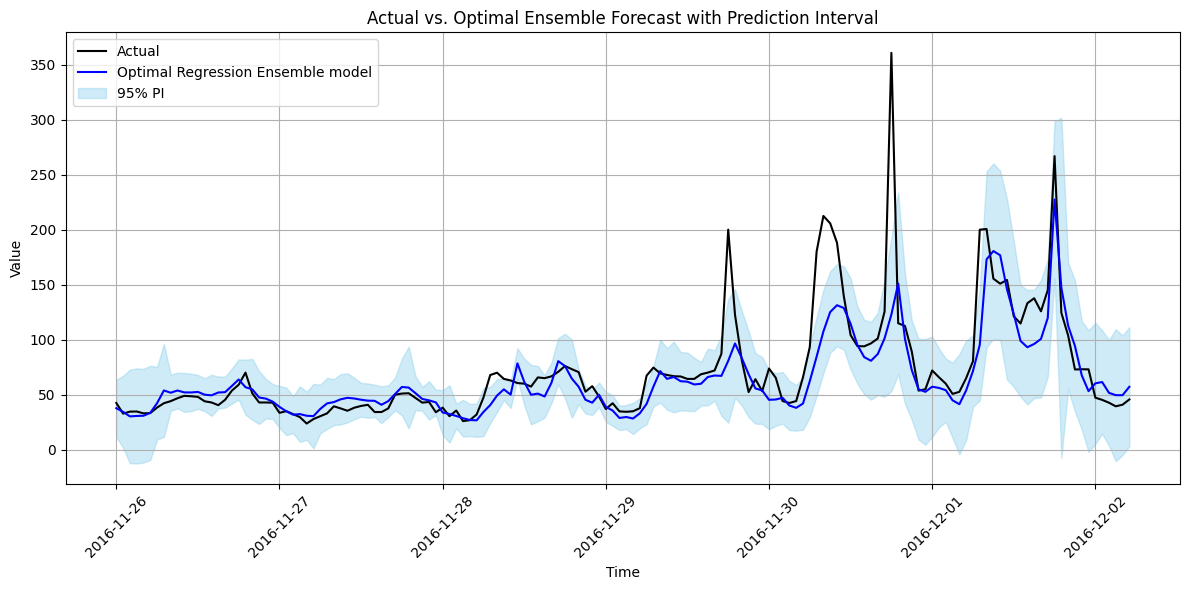

In [ ]:
import matplotlib.pyplot as plt

# Assuming merged_df_1 is your DataFrame with ensemble statistics

# Select the first 200 observations
merged_df_plot = merged_df_1.head(150)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(merged_df_plot['time'], merged_df_plot['actual'], label='Actual', color='black')

# Plot ensemble mean
plt.plot(merged_df_plot['time'], merged_df_plot['ensemble_mean'], label='Optimal Regression Ensemble model', color='blue')

# Plot confidence intervals
plt.fill_between(merged_df_plot['time'], merged_df_plot['ci_lower'], merged_df_plot['ci_upper'], color='skyblue', alpha=0.4, label='95% PI')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Optimal Ensemble Forecast with Prediction Interval')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


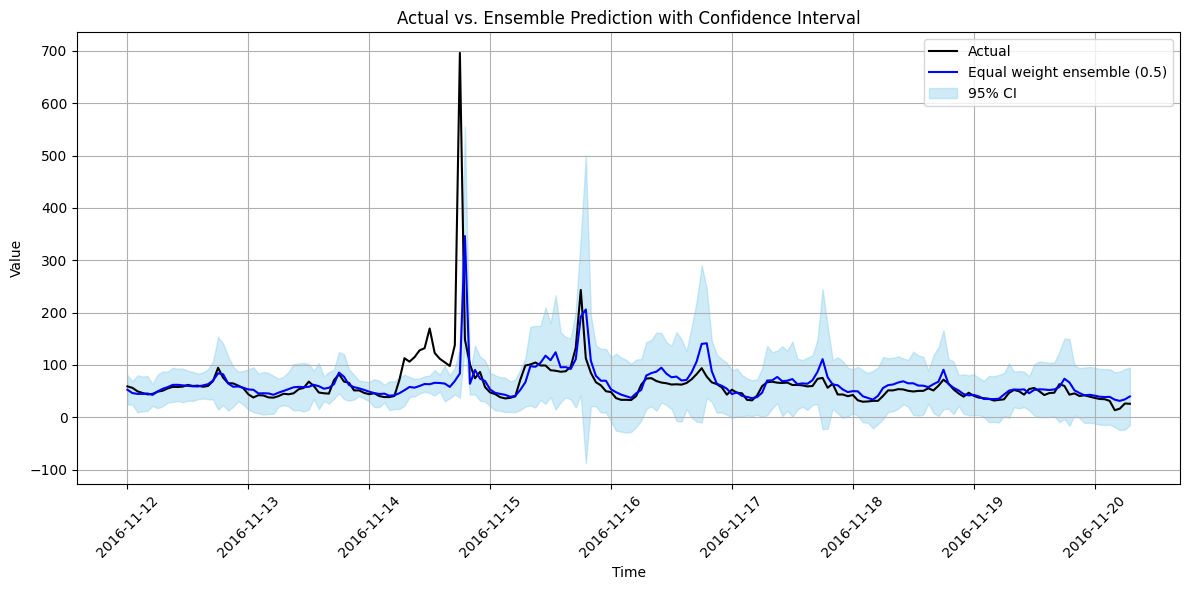

In [ ]:
import matplotlib.pyplot as plt

# Assuming merged_df_1 is your DataFrame with ensemble statistics

# Select the first 200 observations
merged_df_plot = merged_df_2.head(200)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(merged_df_plot['time'], merged_df_plot['actual'], label='Actual', color='black')

# Plot ensemble mean
plt.plot(merged_df_plot['time'], merged_df_plot['ensemble_mean'], label='Equal weight ensemble (0.5)', color='blue')

# Plot confidence intervals
plt.fill_between(merged_df_plot['time'], merged_df_plot['ci_lower'], merged_df_plot['ci_upper'], color='skyblue', alpha=0.4, label='95% CI')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Ensemble Prediction with Confidence Interval')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()